# Colab A: NumPy-Only 3-Layer Deep Neural Network for Non-Linear Regression

**From Scratch — Manual Backpropagation with Chain Rule**

---

### Key Requirements
- 3-layer neural network (3 hidden layers + output)
- Non-linear activation functions (ReLU for hidden, linear for output)
- 3-variable non-linear equation for synthetic data
- `tf.einsum` instead of matrix multiply
- Manual backprop & chain rule gradient propagation
- 4D visualization using PCA dimensionality reduction
- Loss/epoch training curves

## Cell 1: Install & Import Dependencies

In [1]:
import numpy as np
import tensorflow as tf  # Only used for tf.einsum
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

np.random.seed(42)
print(f"NumPy version: {np.__version__}")
print(f"TensorFlow version: {tf.__version__} (used ONLY for tf.einsum)")

NumPy version: 2.0.2
TensorFlow version: 2.19.0 (used ONLY for tf.einsum)


## Cell 2: Define the 3-Variable Non-Linear Equation & Generate Synthetic Data

We use a non-linear equation with 3 input variables:

$$y = \sin(x_1) \cdot x_2^2 + \cos(x_3) \cdot x_1 + 0.5 \cdot x_3 \cdot x_2$$

This creates a complex non-linear surface that requires a deep network to approximate.

In [2]:
# Generate synthetic data from a 3-variable non-linear equation
num_samples = 2000

x1 = np.random.uniform(-2, 2, num_samples)
x2 = np.random.uniform(-2, 2, num_samples)
x3 = np.random.uniform(-2, 2, num_samples)

# Non-linear target function: y = sin(x1)*x2^2 + cos(x3)*x1 + 0.5*x3*x2
y_true = np.sin(x1) * x2**2 + np.cos(x3) * x1 + 0.5 * x3 * x2

# Stack inputs into feature matrix (N, 3)
X = np.column_stack([x1, x2, x3]).astype(np.float32)
Y = y_true.reshape(-1, 1).astype(np.float32)

# Normalize features and targets for stable training
X_mean, X_std = X.mean(axis=0), X.std(axis=0)
Y_mean, Y_std = Y.mean(), Y.std()

X_norm = (X - X_mean) / X_std
Y_norm = (Y - Y_mean) / Y_std

print(f"Input shape: {X_norm.shape}")
print(f"Output shape: {Y_norm.shape}")
print(f"Y range: [{Y.min():.2f}, {Y.max():.2f}]")

Input shape: (2000, 3)
Output shape: (2000, 1)
Y range: [-5.81, 5.73]


## Cell 3: 4D Visualization Using PCA Dimensionality Reduction

Since we have 3 inputs + 1 output (4D data), we use PCA to reduce the 3 input features to 2D for plotting, and use color to represent the target value.

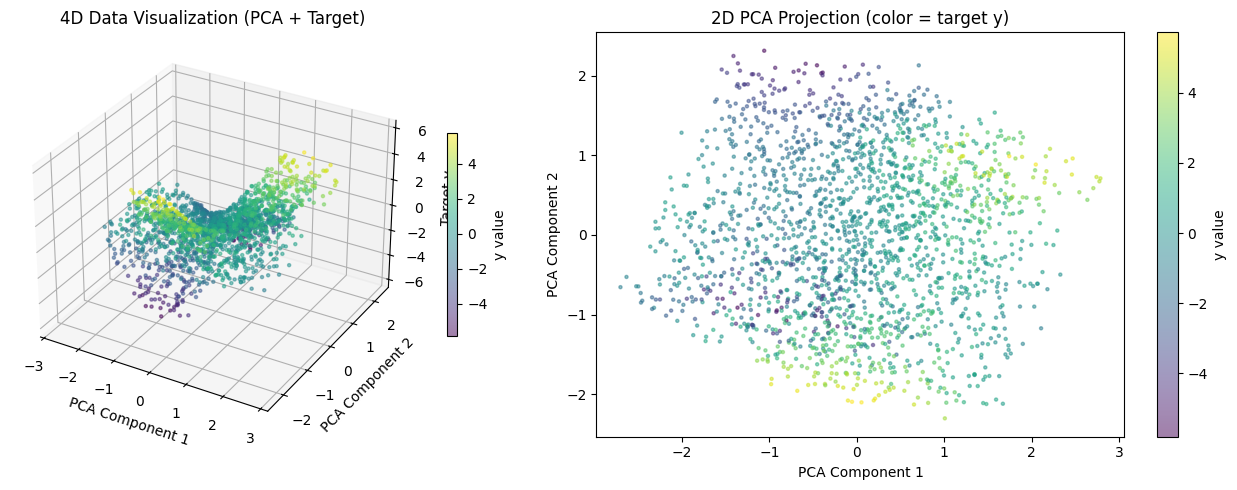

PCA explained variance ratio: [0.34586143 0.33235362]


In [3]:
# 4D Plot: Use PCA to reduce 3 input dims to 2, then plot with y as color and z-axis
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_norm)

fig = plt.figure(figsize=(14, 5))

# 3D scatter: PCA1, PCA2, Y (color = Y value)
ax1 = fig.add_subplot(121, projection='3d')
scatter = ax1.scatter(X_pca[:, 0], X_pca[:, 1], Y.flatten(),
                      c=Y.flatten(), cmap='viridis', alpha=0.5, s=5)
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')
ax1.set_zlabel('Target y')
ax1.set_title('4D Data Visualization (PCA + Target)')
plt.colorbar(scatter, ax=ax1, shrink=0.5, label='y value')

# 2D heatmap view
ax2 = fig.add_subplot(122)
scatter2 = ax2.scatter(X_pca[:, 0], X_pca[:, 1], c=Y.flatten(),
                       cmap='viridis', alpha=0.5, s=5)
ax2.set_xlabel('PCA Component 1')
ax2.set_ylabel('PCA Component 2')
ax2.set_title('2D PCA Projection (color = target y)')
plt.colorbar(scatter2, ax=ax2, label='y value')

plt.tight_layout()
plt.show()

print(f"PCA explained variance ratio: {pca.explained_variance_ratio_}")

## Cell 4: Network Architecture & Weight Initialization

**Architecture:** Input(3) → Hidden1(64, ReLU) → Hidden2(32, ReLU) → Hidden3(16, ReLU) → Output(1, Linear)

We use He initialization for ReLU layers. All matrix multiplications use `tf.einsum`.

In [4]:
# Network architecture: 3 hidden layers
layer_dims = [3, 64, 32, 16, 1]  # input -> h1 -> h2 -> h3 -> output

# He initialization for ReLU activation
def he_init(fan_in, fan_out):
    return np.random.randn(fan_in, fan_out).astype(np.float32) * np.sqrt(2.0 / fan_in)

# Initialize weights and biases for all layers
params = {}
for i in range(len(layer_dims) - 1):
    params[f'W{i+1}'] = he_init(layer_dims[i], layer_dims[i+1])
    params[f'b{i+1}'] = np.zeros((1, layer_dims[i+1]), dtype=np.float32)

print("Network Architecture:")
for i in range(len(layer_dims) - 1):
    activation = 'ReLU' if i < len(layer_dims) - 2 else 'Linear'
    print(f"  Layer {i+1}: ({layer_dims[i]}, {layer_dims[i+1]}) - {activation}")
    print(f"    W{i+1} shape: {params[f'W{i+1}'].shape}, b{i+1} shape: {params[f'b{i+1}'].shape}")

total_params = sum(p.size for p in params.values())
print(f"\nTotal trainable parameters: {total_params}")

Network Architecture:
  Layer 1: (3, 64) - ReLU
    W1 shape: (3, 64), b1 shape: (1, 64)
  Layer 2: (64, 32) - ReLU
    W2 shape: (64, 32), b2 shape: (1, 32)
  Layer 3: (32, 16) - ReLU
    W3 shape: (32, 16), b3 shape: (1, 16)
  Layer 4: (16, 1) - Linear
    W4 shape: (16, 1), b4 shape: (1, 1)

Total trainable parameters: 2881


## Cell 5: Activation Functions & Their Derivatives

In [5]:
def relu(z):
    """ReLU activation: max(0, z)"""
    return np.maximum(0, z)

def relu_derivative(z):
    """Derivative of ReLU: 1 if z > 0, else 0"""
    return (z > 0).astype(np.float32)

# Demonstrate activation
test_z = np.array([-2, -1, 0, 1, 2], dtype=np.float32)
print(f"Input z:       {test_z}")
print(f"ReLU(z):       {relu(test_z)}")
print(f"ReLU'(z):      {relu_derivative(test_z)}")

Input z:       [-2. -1.  0.  1.  2.]
ReLU(z):       [0. 0. 0. 1. 2.]
ReLU'(z):      [0. 0. 0. 1. 1.]


## Cell 6: Forward Pass Using `tf.einsum`

**Key Requirement:** We use `tf.einsum('ij,jk->ik', ...)` instead of `np.matmul` or `np.dot`.

Einstein summation notation: `'ij,jk->ik'` means matrix multiplication where:
- `i` = batch dimension, `j` = summed (contracted) dimension, `k` = output dimension

In [6]:
def forward_pass(X, params):
    """Forward pass through 3-layer network using tf.einsum."""
    cache = {'A0': X}  # Store activations for backprop

    # Layer 1: Input -> Hidden1 (ReLU)
    Z1 = tf.einsum('ij,jk->ik', X, params['W1']).numpy() + params['b1']
    A1 = relu(Z1)
    cache['Z1'], cache['A1'] = Z1, A1

    # Layer 2: Hidden1 -> Hidden2 (ReLU)
    Z2 = tf.einsum('ij,jk->ik', A1, params['W2']).numpy() + params['b2']
    A2 = relu(Z2)
    cache['Z2'], cache['A2'] = Z2, A2

    # Layer 3: Hidden2 -> Hidden3 (ReLU)
    Z3 = tf.einsum('ij,jk->ik', A2, params['W3']).numpy() + params['b3']
    A3 = relu(Z3)
    cache['Z3'], cache['A3'] = Z3, A3

    # Output Layer: Hidden3 -> Output (Linear)
    Z4 = tf.einsum('ij,jk->ik', A3, params['W4']).numpy() + params['b4']
    A4 = Z4  # Linear activation for regression
    cache['Z4'], cache['A4'] = Z4, A4

    return A4, cache

# Quick test
test_out, test_cache = forward_pass(X_norm[:5], params)
print(f"Forward pass output shape: {test_out.shape}")
print(f"Sample predictions: {test_out.flatten()}")

Forward pass output shape: (5, 1)
Sample predictions: [-0.03517491  0.62219006  0.6926325  -0.6958377   0.19943333]


## Cell 7: Loss Function (MSE)

In [7]:
def compute_loss(Y_pred, Y_true):
    """Mean Squared Error loss."""
    m = Y_true.shape[0]
    loss = np.mean((Y_pred - Y_true) ** 2)
    return loss

# Test
initial_pred, _ = forward_pass(X_norm, params)
initial_loss = compute_loss(initial_pred, Y_norm)
print(f"Initial loss (before training): {initial_loss:.4f}")

Initial loss (before training): 0.9510


## Cell 8: Backward Pass — Manual Backpropagation with Chain Rule

**Chain Rule Derivation:**

For MSE loss $L = \frac{1}{m}\sum(\hat{y} - y)^2$:

- $\frac{\partial L}{\partial A_4} = \frac{2}{m}(A_4 - Y)$ (output gradient)
- $\frac{\partial L}{\partial W_l} = A_{l-1}^T \cdot \delta_l$ (weight gradient using einsum)
- $\frac{\partial L}{\partial b_l} = \sum \delta_l$ (bias gradient)
- $\delta_l = \delta_{l+1} \cdot W_{l+1}^T \odot \text{ReLU}'(Z_l)$ (chain rule propagation)

In [8]:
def backward_pass(Y_true, params, cache):
    """Manual backpropagation using chain rule and tf.einsum."""
    m = Y_true.shape[0]
    grads = {}

    # Output layer gradient: dL/dA4 = 2/m * (A4 - Y)
    dA4 = (2.0 / m) * (cache['A4'] - Y_true)
    dZ4 = dA4  # Linear activation derivative = 1

    # Gradients for Layer 4 (output): dW4, db4
    grads['dW4'] = tf.einsum('ij,ik->jk', cache['A3'], dZ4).numpy()
    grads['db4'] = np.sum(dZ4, axis=0, keepdims=True)

    # Backprop to Layer 3: chain rule through W4
    dA3 = tf.einsum('ij,kj->ik', dZ4, params['W4']).numpy()
    dZ3 = dA3 * relu_derivative(cache['Z3'])  # Element-wise multiply with ReLU derivative

    # Gradients for Layer 3
    grads['dW3'] = tf.einsum('ij,ik->jk', cache['A2'], dZ3).numpy()
    grads['db3'] = np.sum(dZ3, axis=0, keepdims=True)

    # Backprop to Layer 2: chain rule through W3
    dA2 = tf.einsum('ij,kj->ik', dZ3, params['W3']).numpy()
    dZ2 = dA2 * relu_derivative(cache['Z2'])

    # Gradients for Layer 2
    grads['dW2'] = tf.einsum('ij,ik->jk', cache['A1'], dZ2).numpy()
    grads['db2'] = np.sum(dZ2, axis=0, keepdims=True)

    # Backprop to Layer 1: chain rule through W2
    dA1 = tf.einsum('ij,kj->ik', dZ2, params['W2']).numpy()
    dZ1 = dA1 * relu_derivative(cache['Z1'])

    # Gradients for Layer 1
    grads['dW1'] = tf.einsum('ij,ik->jk', cache['A0'], dZ1).numpy()
    grads['db1'] = np.sum(dZ1, axis=0, keepdims=True)

    return grads

# Test backward pass
_, test_cache = forward_pass(X_norm, params)
test_grads = backward_pass(Y_norm, params, test_cache)
print("Gradient shapes:")
for key, val in test_grads.items():
    print(f"  {key}: {val.shape}")

Gradient shapes:
  dW4: (16, 1)
  db4: (1, 1)
  dW3: (32, 16)
  db3: (1, 16)
  dW2: (64, 32)
  db2: (1, 32)
  dW1: (3, 64)
  db1: (1, 64)


## Cell 9: Parameter Update (Gradient Descent)

In [9]:
def update_params(params, grads, learning_rate):
    """Update parameters using gradient descent."""
    for i in range(1, 5):  # 4 layers
        params[f'W{i}'] -= learning_rate * grads[f'dW{i}']
        params[f'b{i}'] -= learning_rate * grads[f'db{i}']
    return params

print("Parameter update function ready.")

Parameter update function ready.


## Cell 10: Training Loop with Mini-Batch Gradient Descent

In [10]:
# Hyperparameters
learning_rate = 0.001
epochs = 200
batch_size = 64

# Re-initialize weights
np.random.seed(42)
for i in range(len(layer_dims) - 1):
    params[f'W{i+1}'] = he_init(layer_dims[i], layer_dims[i+1])
    params[f'b{i+1}'] = np.zeros((1, layer_dims[i+1]), dtype=np.float32)

# Training
loss_history = []
num_batches = len(X_norm) // batch_size

for epoch in range(epochs):
    # Shuffle data each epoch
    indices = np.random.permutation(len(X_norm))
    X_shuffled = X_norm[indices]
    Y_shuffled = Y_norm[indices]

    epoch_loss = 0.0
    for batch in range(num_batches):
        start = batch * batch_size
        end = start + batch_size
        X_batch = X_shuffled[start:end]
        Y_batch = Y_shuffled[start:end]

        # Forward pass
        Y_pred, cache = forward_pass(X_batch, params)

        # Compute loss
        batch_loss = compute_loss(Y_pred, Y_batch)
        epoch_loss += batch_loss

        # Backward pass
        grads = backward_pass(Y_batch, params, cache)

        # Update parameters
        params = update_params(params, grads, learning_rate)

    avg_loss = epoch_loss / num_batches
    loss_history.append(avg_loss)

    if (epoch + 1) % 20 == 0 or epoch == 0:
        print(f"Epoch {epoch+1:>3}/{epochs} | Loss: {avg_loss:.6f}")

print(f"\nFinal Training Loss: {loss_history[-1]:.6f}")

Epoch   1/200 | Loss: 0.802536
Epoch  20/200 | Loss: 0.194821
Epoch  40/200 | Loss: 0.105387
Epoch  60/200 | Loss: 0.067955
Epoch  80/200 | Loss: 0.051222
Epoch 100/200 | Loss: 0.043661
Epoch 120/200 | Loss: 0.039067
Epoch 140/200 | Loss: 0.036342
Epoch 160/200 | Loss: 0.034468
Epoch 180/200 | Loss: 0.032777
Epoch 200/200 | Loss: 0.031486

Final Training Loss: 0.031486


## Cell 11: Plot Training Loss Curve

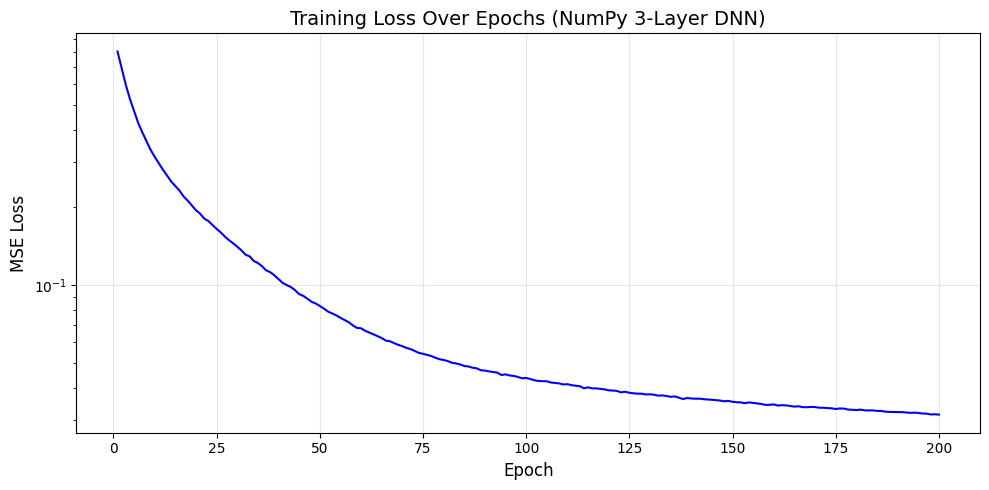

Loss decreased from 0.8025 to 0.031486
Reduction: 96.1%


In [11]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), loss_history, 'b-', linewidth=1.5)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('MSE Loss', fontsize=12)
plt.title('Training Loss Over Epochs (NumPy 3-Layer DNN)', fontsize=14)
plt.grid(True, alpha=0.3)
plt.yscale('log')
plt.tight_layout()
plt.show()

print(f"Loss decreased from {loss_history[0]:.4f} to {loss_history[-1]:.6f}")
print(f"Reduction: {(1 - loss_history[-1]/loss_history[0])*100:.1f}%")

## Cell 12: Final Predictions & Comparison

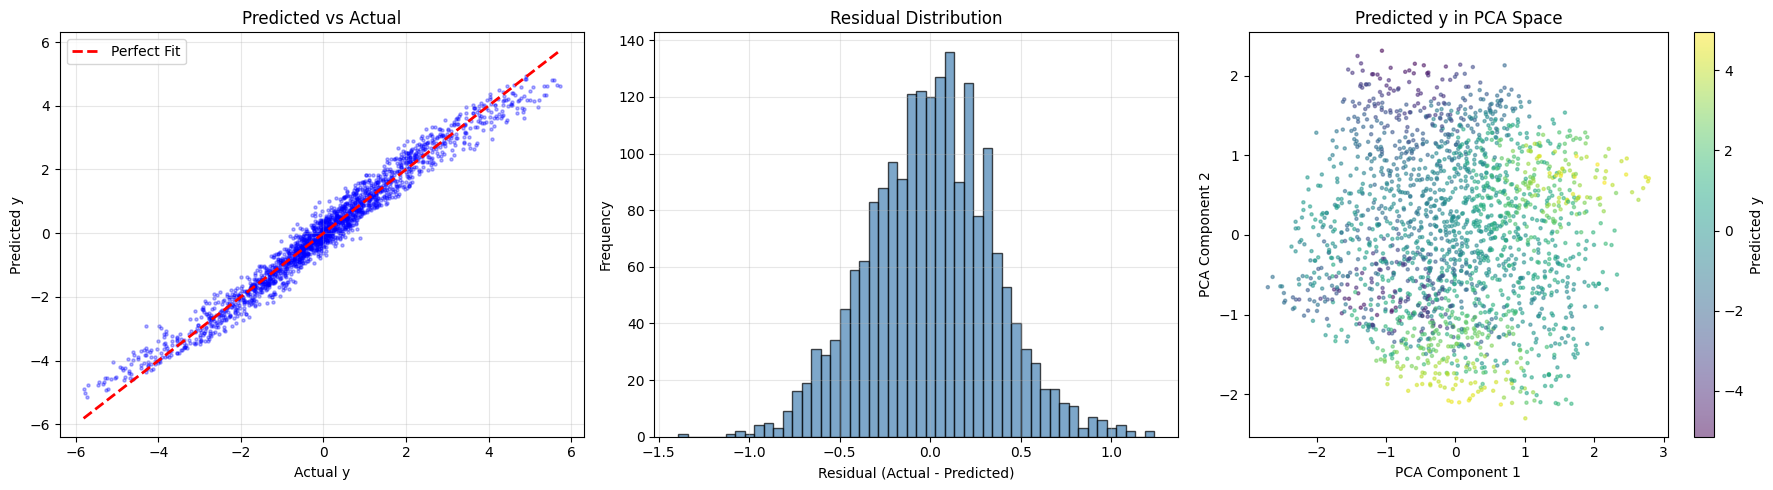


R-squared: 0.9686
Mean Absolute Error: 0.2761
Final MSE: 0.122891


In [12]:
# Final predictions
Y_pred_final, _ = forward_pass(X_norm, params)

# Denormalize predictions
Y_pred_denorm = Y_pred_final * Y_std + Y_mean

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Plot 1: Predicted vs Actual
axes[0].scatter(Y.flatten(), Y_pred_denorm.flatten(), alpha=0.3, s=5, c='blue')
axes[0].plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'r--', linewidth=2, label='Perfect Fit')
axes[0].set_xlabel('Actual y')
axes[0].set_ylabel('Predicted y')
axes[0].set_title('Predicted vs Actual')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Residuals
residuals = Y.flatten() - Y_pred_denorm.flatten()
axes[1].hist(residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
axes[1].set_xlabel('Residual (Actual - Predicted)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Residual Distribution')
axes[1].grid(True, alpha=0.3)

# Plot 3: 4D prediction visualization with PCA
scatter = axes[2].scatter(X_pca[:, 0], X_pca[:, 1], c=Y_pred_denorm.flatten(),
                         cmap='viridis', alpha=0.5, s=5)
axes[2].set_xlabel('PCA Component 1')
axes[2].set_ylabel('PCA Component 2')
axes[2].set_title('Predicted y in PCA Space')
plt.colorbar(scatter, ax=axes[2], label='Predicted y')

plt.tight_layout()
plt.show()

# Compute R-squared
ss_res = np.sum(residuals ** 2)
ss_tot = np.sum((Y.flatten() - Y.mean()) ** 2)
r_squared = 1 - ss_res / ss_tot
print(f"\nR-squared: {r_squared:.4f}")
print(f"Mean Absolute Error: {np.mean(np.abs(residuals)):.4f}")
print(f"Final MSE: {np.mean(residuals**2):.6f}")

## Cell 13: Summary

### What We Built:
1. **3-variable non-linear equation**: $y = \sin(x_1) \cdot x_2^2 + \cos(x_3) \cdot x_1 + 0.5 \cdot x_3 \cdot x_2$
2. **3-layer deep neural network** (3 hidden + 1 output) with ReLU activations
3. **Manual backpropagation** using chain rule — no autograd
4. **`tf.einsum`** for all matrix multiplications
5. **4D visualization** using PCA dimensionality reduction
6. **Training loss curve** showing convergence

In [13]:
print("="*60)
print("Colab A: NumPy From-Scratch 3-Layer DNN — Complete!")
print("="*60)
print(f"Architecture: {layer_dims}")
print(f"Total parameters: {total_params}")
print(f"Final loss: {loss_history[-1]:.6f}")
print(f"R-squared: {r_squared:.4f}")
print(f"Matrix multiply method: tf.einsum")
print(f"Backprop method: Manual chain rule")
print("="*60)

Colab A: NumPy From-Scratch 3-Layer DNN — Complete!
Architecture: [3, 64, 32, 16, 1]
Total parameters: 2881
Final loss: 0.031486
R-squared: 0.9686
Matrix multiply method: tf.einsum
Backprop method: Manual chain rule
